<a href="https://colab.research.google.com/github/crispitagorico/Neural-SPDEs/blob/main/data/generator_navier_stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#clone GitHub repository

In [ ]:
%cd Neural-SPDEs/

In [ ]:
import torch
import numpy as np
from numpy import matlib
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io
import h5py
import pickle
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
from generator_sns import navier_stokes_2d
from random_forcing import GaussianRF
from timeit import default_timer
from random_forcing import GaussianRF, get_twod_bj, get_twod_dW

**Generate data with stochastic forcing**

In [ ]:
filename = '../drive/MyDrive/NS_u0_xi_nu4/'

device = torch.device('cuda')

# Viscosity parameter
nu = 1e-4

# Spatial Resolution
s = 64
sub = 1

# Temporal Resolution   
T = 15
delta_t = 1e-3

# Number of solutions to generate
N = 10

# Set up 2d GRF with covariance parameters
GRF = GaussianRF(2, s, alpha=3, tau=3, device=device)

# Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
t = torch.linspace(0, 1, s+1, device=device)
t = t[0:-1]

X,Y = torch.meshgrid(t, t)
f = 0.1*(torch.sin(2*math.pi*(X + Y)) + torch.cos(2*math.pi*(X + Y)))

# Stochastic forcing function: sigma*dW/dt 
stochastic_forcing = {'alpha':0.005, 'kappa':10, 'sigma':0.05}

# Number of snapshots from solution
record_steps = int(T/(delta_t))

# Solve equations in batches (order of magnitude speed-up)

# Batch size
bsize = 10

c = 0
t0 =default_timer()

#Sample random fields
# w0 = GRF.sample(1).repeat(bsize,1,1)

for j in range(N//bsize):

    w0 = GRF.sample(bsize)

    sol, sol_t, forcing = navier_stokes_2d([1,1], w0, f, nu, T, delta_t, record_steps, stochastic_forcing)  
    
    # add time 0
    time = torch.zeros(record_steps+1)
    time[1:] = sol_t.cpu()
    sol = torch.cat([w0[...,None],sol],dim=-1)
    forcing = torch.cat([torch.zeros_like(w0)[...,None],forcing],dim=-1)

    c += bsize
    t1 = default_timer()
    print(j, c, t1-t0)

    # scipy.io.savemat(filename+'{}.mat'.format(j), mdict={'t':time.numpy(), 'sol': sol.cpu().numpy(), 'forcing': forcing.cpu().numpy(), 'param':stochastic_forcing})
    # scipy.io.savemat(filename+'small_{}.mat'.format(j), mdict={'t': time[::4].numpy(), 'sol': sol[:,::4,::4,::4].cpu().numpy(), 'forcing': forcing[:,::4,::4,::4].cpu().numpy(), 'param':stochastic_forcing})

  0%|          | 0/7500 [00:00<?, ?it/s]

0 10 10.339991929999997


**Visualize noise**

In [ ]:
times = np.linspace(0,record_steps,3)
fig, ax = plt.subplots(3,3,figsize=(5,5))
for i,t in enumerate(times):
  t = int(times[i])
  for k in range(3):
    ax[k][i].contourf(forcing[k,...,t].cpu(),50,cmap=plt.cm.jet)
    ax[k][i].set_title('t={}'.format(t))
    ax[k][i].set_ylabel('sample {}'.format(k))
plt.tight_layout()
plt.show()

**Visualize solutions**

In [ ]:
times = np.linspace(0,record_steps,5)
fig, ax = plt.subplots(5,5,figsize=(10,10))

for i in range(5):
  t = int(times[i])
  for k in range(5):
    ax[k][i].contourf(sol[k,...,t].cpu(),25,cmap=plt.cm.jet)
    ax[k][i].set_title('t={}'.format(t))
    ax[k][i].set_ylabel('sample {}'.format(k))
plt.tight_layout()
plt.show()

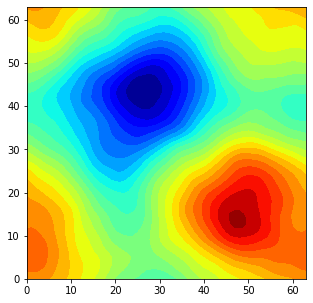

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

def animate(t):
    plt.cla()
    plt.contourf(sol[0,...,150*t].cpu().detach(),25,cmap=plt.cm.jet)

matplotlib.animation.FuncAnimation(fig, animate, frames=100)